In [3]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from pysr import PySRRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from torch.optim import LBFGS
import math

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.2 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.2-linux-x86_64.tar.gz
             download complete
[juliapkg] Verifying download


In [1]:
import torch
import numpy as np
import random

# Set the random seed for reproducibility
random.seed(42)  # For Python's built-in random module
np.random.seed(42)  # For NumPy
torch.manual_seed(42)  # For PyTorch (CPU)
torch.cuda.manual_seed_all(42)

In [2]:
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    for file in files:  # Clean up intermediate files
        os.remove(file)


# Alzheimer's and Control Reaction Terms

def alzheimers_reaction_term(c):
    return 0.23 * c ** 3 - 1.34 * c ** 2 + 1.11 * c

def control_reaction_term(c):
    return -c ** 3 + 0.62 * c ** 2 + 0.39 * c

# Generate synthetic data based on reaction term and diffusion coefficient

def synthetic_data(t, reaction_term, diffusion_coeff, alpha):
    def tau_ode(c, t):
        return - diffusion_coeff * c + alpha * reaction_term(c)
    c_init = 0.1
    c = odeint(tau_ode, c_init, t)
    return c

# Define time points and diffusion coefficient
t = torch.linspace(0, 10, 10).reshape(-1, 1)
diffusion_coeff = 0.18
alpha = 0.8

# Generate Alzheimer's and Control synthetic data

alzheimers_data = synthetic_data(t.numpy().flatten(), alzheimers_reaction_term, diffusion_coeff, alpha)

# Convert each data into a torch tensor

c_alzheimers = torch.tensor(alzheimers_data, dtype=torch.float32)

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Network to approximate concentration c
        self.net_c = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        # Network to approximate the reaction term f(c)
        self.net_f = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t):
        c = self.net_c(t)
        f = self.net_f(c)
        return c, f

# PDE loss function for the PINN
def pde_loss(pinn, t, c, diffusion_coeff, alpha):
    t.requires_grad = True
    c_pred, f_pred = pinn(t)
    # Data loss (mean squared error)
    data_loss = nn.MSELoss()(c_pred, c)

    # PDE loss
    c_t = torch.autograd.grad(c_pred.sum(), t, create_graph=True)[0]
    diffusion_term =  - diffusion_coeff * c_pred
    pde_residual = c_t - diffusion_term -  alpha * f_pred
    pde_loss = (pde_residual ** 2).mean()

    return data_loss + pde_loss

# Function to train PINN using Adam and L-BFGS
def train_pinn(pinn, t, c, diffusion_coeff, alpha, adam_epochs=10000, lbfgs_epochs=10000, lr=0.0001):

    files = []

    adam_loss_history = []
    BFGS_loss_history = []

    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(pinn.parameters(), lr=lr)
    print("Training with Adam...")
    for epoch in range(adam_epochs):
        loss = pde_loss(pinn, t, c, diffusion_coeff, alpha)
        adam_loss_history.append(loss.item())
        optimizer_adam.zero_grad()
        loss.backward()
        optimizer_adam.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, loss: {loss.item()}')
            c_pred, _ = pinn(t)
            plt.figure(figsize=(10, 6))
            plt.plot(t.detach().numpy(), c.detach().numpy(), 'o', label="True Data")
            plt.plot(t.detach().numpy(), c_pred.detach().numpy(), '-', label="PINN Prediction")
            plt.xlabel("Time")
            plt.ylabel("Concentration")
            plt.legend()
            file = f"pinn_adam_epoch_{epoch}.png"
            plt.savefig(file)
            files.append(file)
            plt.close()

    # L-BFGS optimizer for fine-tuning
    optimizer_lbfgs = LBFGS(pinn.parameters(), lr=lr, max_iter=lbfgs_epochs)
    print("Training with L-BFGS...")

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = pde_loss(pinn, t, c, diffusion_coeff, alpha)
        loss.backward()
        return loss

    for epoch in range(lbfgs_epochs):
        loss = optimizer_lbfgs.step(closure)
        BFGS_loss_history.append(loss.item())

        if epoch % 1000 == 0:
            print(f'L-BFGS Iteration {epoch}, loss: {loss.item()}')
            c_pred, _ = pinn(t)
            plt.figure(figsize=(10, 6))
            plt.plot(t.detach().numpy(), c.detach().numpy(), 'o', label="True Data")
            plt.plot(t.detach().numpy(), c_pred.detach().numpy(), '-', label="PINN Prediction")
            plt.xlabel("Time")
            plt.ylabel("Concentration")
            plt.legend()
            file = f"pinn_lbfgs_epoch_{epoch}.png"
            plt.savefig(file)
            files.append(file)
            plt.close()

    save_gif("pinn_training.gif", files, fps=3, loop=0)
    # Plotting the loss history
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(adam_loss_history)), adam_loss_history, label='Adam', color='red')
    plt.plot(np.arange(len(adam_loss_history), len(adam_loss_history) + len(BFGS_loss_history)),
             BFGS_loss_history, label='L-BFGS', color='blue')
    plt.yscale('log')
    plt.axvline(len(adam_loss_history), color='black', linestyle='--', label='Optimizer switch')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('PINN Loss')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    loss_plot_file = "pinn_loss_plot.png"
    plt.savefig(loss_plot_file)
    plt.show()

# Initialize and train PINN for Alzheimer's data
pinn_alzheimer = PINN()
train_pinn(pinn_alzheimer, t, c_alzheimers, diffusion_coeff, alpha)


# Perform symbolic regression on f_pred for each group
def symbolic_regression(pinn, c):
    c_vals = c.detach().numpy()
    f_vals = pinn.net_f(c).detach().numpy()
    symbolic_regressor = PySRRegressor(
        niterations=40,
        binary_operators=["+", "*"],
    )
    symbolic_regressor.fit(c_vals, f_vals)
    return symbolic_regressor

# Symbolic regression on Alzheimer's reaction term
symbolic_regressor_alz = symbolic_regression(pinn_alzheimer, c_alzheimers)
print("Discovered Alzheimer's reaction model:", symbolic_regressor_alz.get_best())



# Plot the synthetic data for both groups
plt.figure(figsize=(10,6))
plt.plot(t.detach().numpy(), c_alzheimers.detach().numpy(), 'o', label="Alzheimer's Synthetic Data")
plt.plot(t.detach().numpy(), pinn_alzheimer.net_c(t.reshape(-1, 1)).detach().numpy(), label="PINN Prediction")
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

NameError: name 'odeint' is not defined

In [ ]:
from sympy import pretty

best_eq_sympy_alz = symbolic_regressor_alz.sympy()

print("Symbolic Regression Equation for Alzheimer's:")
print(pretty(best_eq_sympy_alz))

Symbolic Regression Equation for Alzheimer's:
(0.84351635 + x₀⋅-0.7416543)⋅(0.92050916 + x₀⋅-0.77932596)⋅(x₀ + 0.25574374)⋅(x₀ + x₀ + 0.3134582)


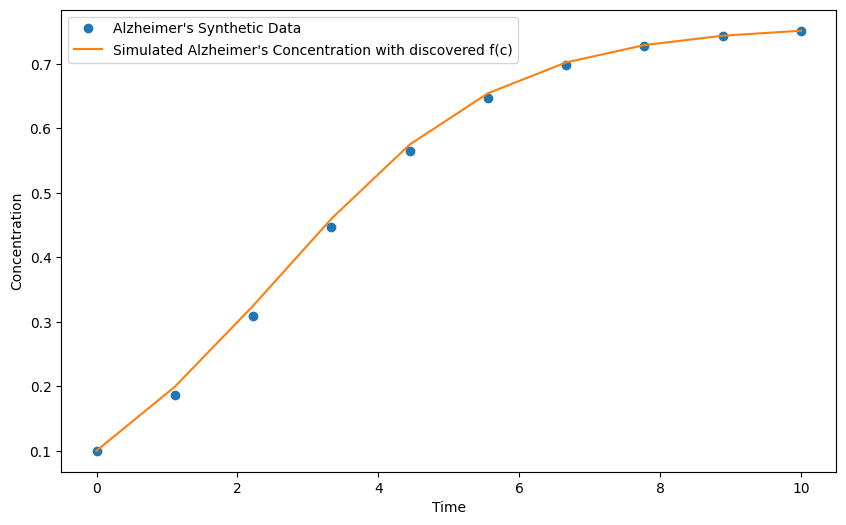

In [ ]:
# Use the discovered symbolic regression models
def f_sym_alz(c):
    return symbolic_regressor_alz.predict(c.reshape(-1, 1))
# Define the ODE system using f_sym for each group and simulate
def reaction_diffusion_ode(c, t, diffusion_coeff, alpha,  f_sym):
    return - diffusion_coeff * c + alpha * f_sym(c)

# Simulate concentration over an extended time period for Alzheimer's
time_points = np.linspace(0, 10, 10)
alzheimers_simulated = odeint(reaction_diffusion_ode, [0.1], time_points, args=(diffusion_coeff, alpha, f_sym_alz))

# Plot simulation results
plt.figure(figsize=(10,6))
plt.plot(t.detach().numpy(), c_alzheimers.detach().numpy(), 'o', label="Alzheimer's Synthetic Data")
plt.plot(time_points, alzheimers_simulated, label=f"Simulated Alzheimer's Concentration with discovered f(c)")
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [ ]:
import re
import google.generativeai as genai
from google.colab import userdata
GEMINI_KEY = userdata.get("GEMINI_KEY")

genai.configure(api_key=GEMINI_KEY)

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash")


prompt = f"""
persona: You are a proffiecinal neurological doctor.
context: We are trying to predict Alzheimer's disease by modeling tau misofold in the brain over 10 years by solving the reaction-diffusion equation and getting the reaction term f(c)
using PINN and symbolic regression.

text: I will give the the predicted f(c) from the symbolic regression.
First, formulate the equation in a interpretable mathimatical representaion with just + and - (e.g. c^3 + c^2 + c).
Secondly, I want you to give me a details insights based on this equation like a doctor comparing it with the normal people equation.
Eventually, give me some tips to prevent Alzheimer's disease.

Inputs:
f(c) of healthy people = -c ** 3 + 0.62 * c ** 2 + 0.39 * c
predicted alzheimer's f(c) = {best_eq_sympy_alz}
protien to be modeled = tau misofold in the brain

Output:
A polished and well-written doctor like report
"""
response = model.generate_content(prompt)

In [ ]:
with open('report.txt', 'w') as f:
  text = re.sub(r'[*#-]', '', response.text)
  f.write(text)